# Importing Libraries

In [1]:
import numpy as np
import cv2
import dlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from skimage import feature
import datetime
import pandas as pd

# Interfacing Webcam

In [2]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    cv2.imshow("preview", frame)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
cv2.destroyWindow("preview")

# Face Detection (Haar Feature Based)

In [3]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        if (w>120 or h>120):
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

# Generating Log of Faces

In [ ]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

video_capture = cv2.VideoCapture(0)

count=100
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    # Draw a rectangle around the faces
    count+=1
    for (x, y, w, h) in faces:
        if (w>120 or h>120):
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), thickness=4)
            #Save just the rectangle faces in SubRecFaces
            sub_face = frame[y:y+h, x:x+w]
            cv2.imwrite('C:/Users/user/training/focused/fface'+str(count)+".jpg", sub_face)

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

# Feature Extraction of Faces (Local Binary Pattern)

C:\Users\user\Anaconda3\envs\ame\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


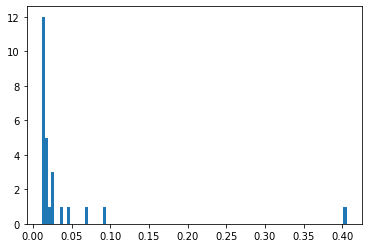

In [4]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import cv2
import os
import pickle
from scipy.misc import imread

 
from skimage import feature
import numpy as np
 
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, self.numPoints + 3),range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # return the histogram of Local Binary Patterns
        return hist
desc = LocalBinaryPatterns(24, 8)
im = imread("fface126.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
lbp = desc.describe(gray)
plt.hist(lbp, bins=100)
plt.show()

In [5]:
# initialize the local binary patterns descriptor along with
# the data and label lists
p=24
r=8
desc = LocalBinaryPatterns(p, r)
data = []
labels = []

# Training SVM Model

In [ ]:
# loop over the training images
for cls in os.listdir("C:/Users/user/training"):
    clspath = os.path.join("C:/Users/user/training",cls)
    for file in os.listdir(clspath):
        # load the image, convert it to grayscale, and describe it
        imagePath = os.path.join(clspath,file)
        image = cv2.imread(imagePath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hist = desc.describe(gray)

        # extract the label from the image path, then update the
        # label and data lists
        labels.append(cls)
        data.append(hist)
 
#Train a Linear SVM on the data
model1 = LinearSVC(C=500.0)
model1.fit(data, labels)
pickle.dump(model1,open("C:/Users/user/modelling.pkl", 'wb'))

# Testing SVM Model

In [ ]:
for cls in os.listdir("C:/Users/user/test"):
    clspath = os.path.join("C:/Users/user/test",cls)
    for file in os.listdir(clspath):
        # load the image, convert it to grayscale, describe it,
        # and classify it
        imagePath = os.path.join(clspath,file)
        image = cv2.imread(imagePath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hist = desc.describe(gray)
        prediction = model1.predict(hist.reshape(1, -1))

        # display the image and the prediction
        cv2.putText(image, prediction[0], (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            1.0, (0, 0, 255), 3)
        cv2.imshow("Image", image)
        cv2.waitKey(0)

# Real Time Emotion Recognition

In [9]:
import pickle
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)
model = pickle.load(open("C:/Users/user/modelling.pkl", 'rb'))
desc = LocalBinaryPatterns(24, 8)
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
video_capture = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640,480))
timestamps = []
status = []

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        if (w>120 or h>120):
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), thickness=4)
            #Save just the rectangle faces in SubRecFaces
            sub_face = frame[y:y+h, x:x+w]
            gray = cv2.cvtColor(sub_face, cv2.COLOR_BGR2GRAY)
            hist = desc.describe(gray)
            prediction = model.predict(hist.reshape(1, -1))

        # display the image and the prediction
            cv2.putText(frame, prediction[0], (x, y), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255),3, cv2.LINE_AA)
            timestamps.append(datetime.datetime.now().time())
            status.append(prediction[0])

    cv2.imshow("preview", frame)
    out.write(frame)
    key = cv2.waitKey(1)
    if key == 27: # exit on ESC
        break
video_capture.release()
out.release()
cv2.destroyAllWindows()

In [10]:
state = []
for i in range(len(status)):
    if (status[i]=='notfocused' or status[i]=='moderatelyfocused'):
        state.append(0)
    else:
        state.append(1)
d = {'Time Stamp':timestamps,'Status':state}
df = pd.DataFrame(d)
df.to_csv('trackeddata.csv') 